In [8]:
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(root_path)

import json
import pandas as pd
import re
from src.value_adding_analysis import compare_value_classifications
from src.common.models import ValueAddingAnalysis


def extract_file_info(filename):
    pattern = r"(GPT-\d+(?:\.\d+)?)-Value-Classification-(.+)_response\.json"
    match = re.match(pattern, filename)
    if match:
        return match.group(1), match.group(2)  # GPT version, Model name
    return None, None

def process_json_file(activity, ground_truth_path, response_path):
    with open(response_path, 'r') as file:
        data = json.load(file)
    
    with open(ground_truth_path, 'r') as file:
        gt_data = json.load(file)
    
    # metrics = data.get('metrics', {})
    
    # Compare results
    response_dict = data.get('response', {})
    metrics = compare_value_classifications(response_dict, gt_data).to_dict()
    
    # Extract basic metrics
    total_substeps = metrics.get("total_substeps", 0)
    correct_classifications = metrics.get("correct_classifications", 0)
    accuracy = metrics.get("accuracy", 0)
    num_misclassifications = len(metrics.get("misclassifications", []))
    
    # Extract full confusion matrix
    confusion_matrix = metrics.get("confusion_matrix", {})
    
    # Create a dictionary to store all metrics
    result = {
        'total_substeps': total_substeps,
        'correct_classifications': correct_classifications,
        'accuracy': accuracy*100,
        'num_misclassifications': num_misclassifications,
    }
    
    # Add confusion matrix data to the result
    for true_label, predictions in confusion_matrix.items():
        for predicted_label, count in predictions.items():
            result[f'conf_{true_label}_{predicted_label}'] = count
    
    return result

def process_directory(ground_truth_dir, response_dir):
    records = []
    for sector in os.listdir(response_dir):
        sector_path = os.path.join(response_dir, sector)
        if os.path.isdir(sector_path):
            for activity in os.listdir(sector_path):
                activity_gt_path = os.path.join(ground_truth_dir, sector, activity)
                activity_response_path = os.path.join(sector_path, activity)
                if os.path.isdir(activity_response_path):
                    for filename in os.listdir(activity_response_path):
                        if filename.endswith("_response.json") and "Value-Classification" in filename:
                            gpt_version, model_name = extract_file_info(filename)
                            if gpt_version and model_name:
                                file_path = os.path.join(activity_response_path, filename)
                                ground_truth_path = os.path.join(activity_gt_path, f"{activity}_step_value_analysis.json")
                                metrics = process_json_file(activity, ground_truth_path, file_path)
                                records.append({
                                    'sector': sector,
                                    'activity': activity,
                                    'gpt_version': gpt_version,
                                    'model_name': model_name,
                                    **metrics  # Unpack all metrics into the record
                                })
    return pd.DataFrame(records)

TRAIN = False

dir = "train" if TRAIN else "test"

# Set the base directory
ROOT_DIR = r"C:\Projects\Research\SWEEP\SWEEP"
ground_truth_directory = os.path.join("data", dir)
response_directory = os.path.join(r"test\results\value_adding_analysis", dir)
ground_truth_dir = os.path.join(ROOT_DIR, ground_truth_directory)
response_dir = os.path.join(ROOT_DIR, response_directory)
data_df = process_directory(ground_truth_dir, response_dir)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 300)

# Preview the DataFrame
print(data_df.head())
print(data_df.columns)
print(data_df.size)

    sector           activity gpt_version                      model_name  total_substeps  correct_classifications   accuracy  num_misclassifications  conf_BVA_VA  conf_BVA_NVA  conf_BVA_BVA  conf_VA_VA  conf_VA_BVA  conf_VA_Unclassified  conf_NVA_BVA  conf_BVA_Unclassified
0  banking  credibility_check     GPT-3.5   Business_Consultant_Strategic              47                       20  42.553191                      27         12.0           1.0           9.0        11.0         10.0                   1.0           3.0                    NaN
1  banking  credibility_check     GPT-3.5  Customer_Advocate_ValueFocused              47                       19  40.425532                      28         12.0           1.0           9.0        10.0         10.0                   2.0           3.0                    NaN
2  banking  credibility_check     GPT-3.5            Lean_Expert_Detailed              47                       19  40.425532                      28         12.0           1.

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

def calculate_metrics(group):
    # Extract available confusion matrix values
    # VA (Value Adding)
    tp_va = group['conf_VA_VA'].sum()
    fp_va = group['conf_BVA_VA'].sum() if 'conf_BVA_VA' in group.columns else 0
    fn_va = group['conf_VA_BVA'].sum() + group['conf_VA_Unclassified'].sum()
    
    # BVA (Business Value Adding)
    tp_bva = group['conf_BVA_BVA'].sum()
    fp_bva = group['conf_VA_BVA'].sum() + group['conf_NVA_BVA'].sum()
    fn_bva = group['conf_BVA_VA'].sum() + group['conf_BVA_NVA'].sum() + group['conf_BVA_Unclassified'].sum()
    
    # NVA (Non-Value Adding) - we don't have direct NVA confirmations in the data
    tp_nva = 0  # Since we don't have conf_NVA_NVA
    fp_nva = group['conf_BVA_NVA'].sum() if 'conf_BVA_NVA' in group.columns else 0
    fn_nva = 0  # Since we don't have conf_NVA_VA or conf_NVA_BVA
    
    # Calculate precision, recall, and F1 for each class
    metrics = {}
    for class_name, tp, fp, fn in [('VA', tp_va, fp_va, fn_va), 
                                  ('BVA', tp_bva, fp_bva, fn_bva), 
                                  ('NVA', tp_nva, fp_nva, fn_nva)]:
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[f'{class_name}_precision'] = precision
        metrics[f'{class_name}_recall'] = recall
        metrics[f'{class_name}_f1'] = f1
    
    # Calculate macro averages
    macro_precision = np.mean([metrics['VA_precision'], metrics['BVA_precision'], metrics['NVA_precision']])
    macro_recall = np.mean([metrics['VA_recall'], metrics['BVA_recall'], metrics['NVA_recall']])
    macro_f1 = np.mean([metrics['VA_f1'], metrics['BVA_f1'], metrics['NVA_f1']])
    
    # Calculate weighted averages
    total = tp_va + tp_bva + tp_nva + fp_va + fp_bva + fp_nva + fn_va + fn_bva + fn_nva
    if total > 0:
        weighted_precision = (metrics['VA_precision'] * (tp_va + fp_va) + 
                            metrics['BVA_precision'] * (tp_bva + fp_bva) + 
                            metrics['NVA_precision'] * (tp_nva + fp_nva)) / total
        weighted_recall = (metrics['VA_recall'] * (tp_va + fn_va) + 
                         metrics['BVA_recall'] * (tp_bva + fn_bva) + 
                         metrics['NVA_recall'] * (tp_nva + fn_nva)) / total
        weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall) if (weighted_precision + weighted_recall) > 0 else 0
    else:
        weighted_precision = weighted_recall = weighted_f1 = 0
    
    # Prepare data for Cohen's Kappa and MCC
    # Only include classes that have actual data
    y_true_parts = []
    y_pred_parts = []
    
    if tp_va + fn_va > 0:
        y_true_parts.append(['VA'] * int(tp_va + fn_va))
    if tp_bva + fn_bva > 0:
        y_true_parts.append(['BVA'] * int(tp_bva + fn_bva))
    if tp_nva + fn_nva > 0:
        y_true_parts.append(['NVA'] * int(tp_nva + fn_nva))
        
    if tp_va + fp_va > 0:
        y_pred_parts.append(['VA'] * int(tp_va + fp_va))
    if tp_bva + fp_bva > 0:
        y_pred_parts.append(['BVA'] * int(tp_bva + fp_bva))
    if tp_nva + fp_nva > 0:
        y_pred_parts.append(['NVA'] * int(tp_nva + fp_nva))
    
    y_true = np.concatenate(y_true_parts) if y_true_parts else np.array([])
    y_pred = np.concatenate(y_pred_parts) if y_pred_parts else np.array([])
    
    # Calculate Cohen's Kappa and MCC only if we have enough data
    if len(y_true) > 0 and len(y_pred) > 0 and len(y_true) == len(y_pred):
        try:
            cohen_kappa = cohen_kappa_score(y_true, y_pred)
            mcc = matthews_corrcoef(y_true, y_pred)
        except ValueError:
            cohen_kappa = mcc = 0
    else:
        cohen_kappa = mcc = 0
    
    # Compile all metrics
    metrics.update({
        'accuracy': group['accuracy'].mean(),
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1': weighted_f1,
        'cohen_kappa': cohen_kappa,
        'matthews_corrcoef': mcc
    })
    
    return pd.Series(metrics)

# Apply the function to each group
result = data_df.groupby(['model_name', 'gpt_version']).apply(calculate_metrics).reset_index()

Top 3 Models based on Weighted F1 Score:
                      model_name gpt_version  weighted_f1  macro_f1   accuracy  cohen_kappa  matthews_corrcoef
0  Business_Consultant_Strategic     GPT-3.5     0.446927  0.407448  46.243813          0.0                0.0
3          Neutral_Analyst_Basic     GPT-3.5     0.444134  0.404724  46.299500          0.0                0.0
5     Process_Engineer_Technical     GPT-3.5     0.444134  0.406475  46.114238          0.0                0.0

Detailed metrics for the best performing model:
Model: Business_Consultant_Strategic (GPT version: GPT-3.5)
Weighted F1: 0.4469
Macro F1: 0.4074
Accuracy: 46.2438
Cohen's Kappa: 0.0000
Matthews Correlation Coefficient: 0.0000

Class-wise metrics for the best model:
VA:
  Precision: 0.6364
  Recall: 0.7101
  F1 Score: 0.6712
BVA:
  Precision: 0.6327
  Recall: 0.4882
  F1 Score: 0.5511
NVA:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


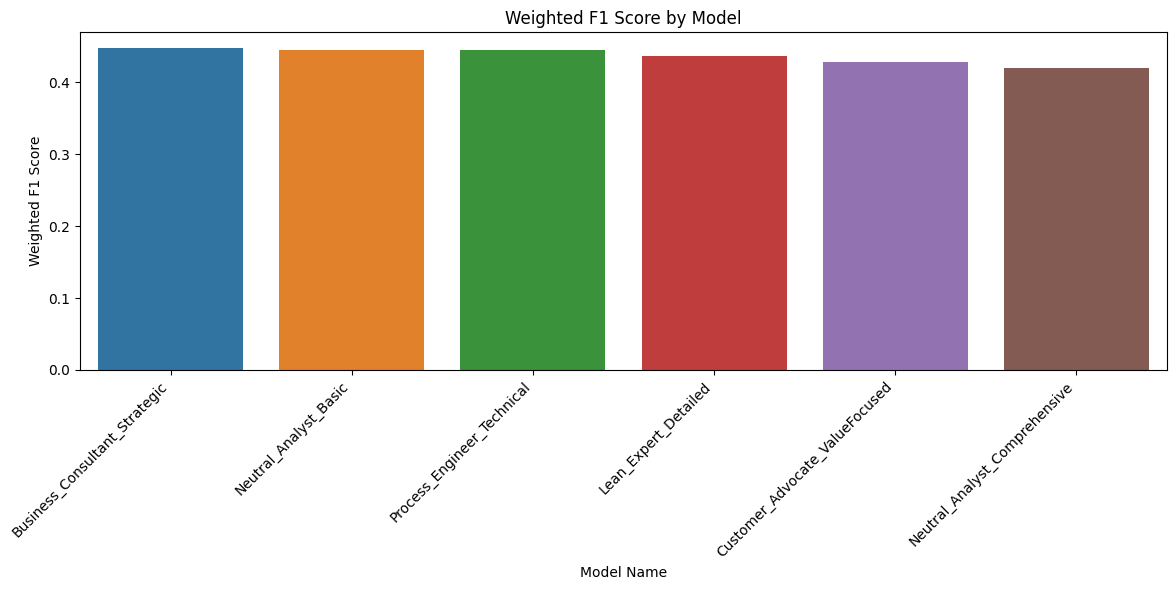

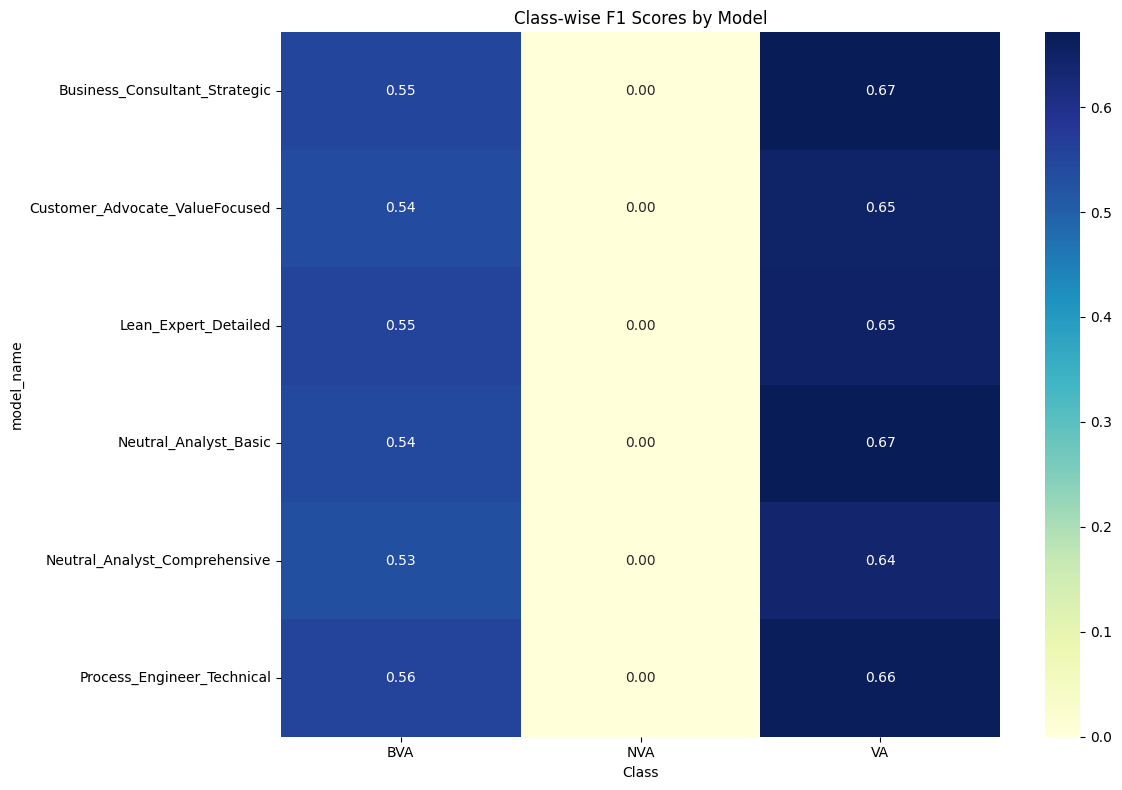

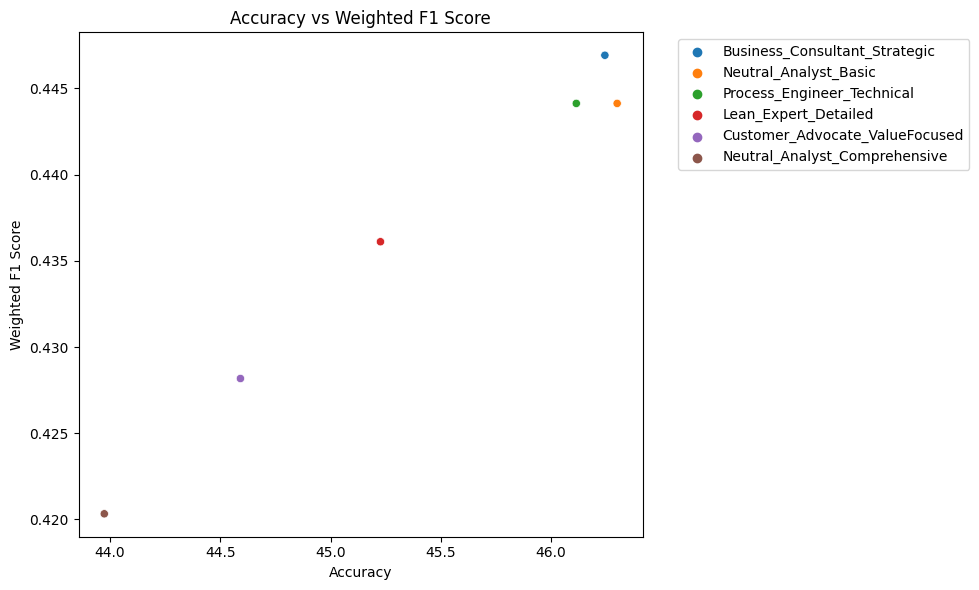

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the results by weighted F1 score in descending order
result_sorted = result.sort_values('weighted_f1', ascending=False)

# Display the top 3 models based on weighted F1 score
print("Top 3 Models based on Weighted F1 Score:")
print(result_sorted[['model_name', 'gpt_version', 'weighted_f1', 'macro_f1', 'accuracy', 'cohen_kappa', 'matthews_corrcoef']].head(3))

print("\nDetailed metrics for the best performing model:")
best_model = result_sorted.iloc[0]
print(f"Model: {best_model['model_name']} (GPT version: {best_model['gpt_version']})")
print(f"Weighted F1: {best_model['weighted_f1']:.4f}")
print(f"Macro F1: {best_model['macro_f1']:.4f}")
print(f"Accuracy: {best_model['accuracy']:.4f}")
print(f"Cohen's Kappa: {best_model['cohen_kappa']:.4f}")
print(f"Matthews Correlation Coefficient: {best_model['matthews_corrcoef']:.4f}")

print("\nClass-wise metrics for the best model:")
for class_name in ['VA', 'BVA', 'NVA']:
    print(f"{class_name}:")
    print(f"  Precision: {best_model[f'{class_name}_precision']:.4f}")
    print(f"  Recall: {best_model[f'{class_name}_recall']:.4f}")
    print(f"  F1 Score: {best_model[f'{class_name}_f1']:.4f}")

# Visualize the performance of all models
plt.figure(figsize=(12, 6))
sns.barplot(x='model_name', y='weighted_f1', data=result_sorted)
plt.title('Weighted F1 Score by Model')
plt.xlabel('Model Name')
plt.ylabel('Weighted F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Heatmap of class-wise F1 scores
class_f1_scores = result_sorted[['model_name', 'VA_f1', 'BVA_f1', 'NVA_f1']]
class_f1_scores_pivot = class_f1_scores.melt(id_vars=['model_name'], var_name='Class', value_name='F1 Score')
class_f1_scores_pivot['Class'] = class_f1_scores_pivot['Class'].str.replace('_f1', '')

plt.figure(figsize=(12, 8))
sns.heatmap(class_f1_scores_pivot.pivot(index='model_name', columns='Class', values='F1 Score'), 
            annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Class-wise F1 Scores by Model')
plt.tight_layout()
plt.show()

# Scatter plot of Accuracy vs Weighted F1 Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accuracy', y='weighted_f1', data=result_sorted, hue='model_name')
plt.title('Accuracy vs Weighted F1 Score')
plt.xlabel('Accuracy')
plt.ylabel('Weighted F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

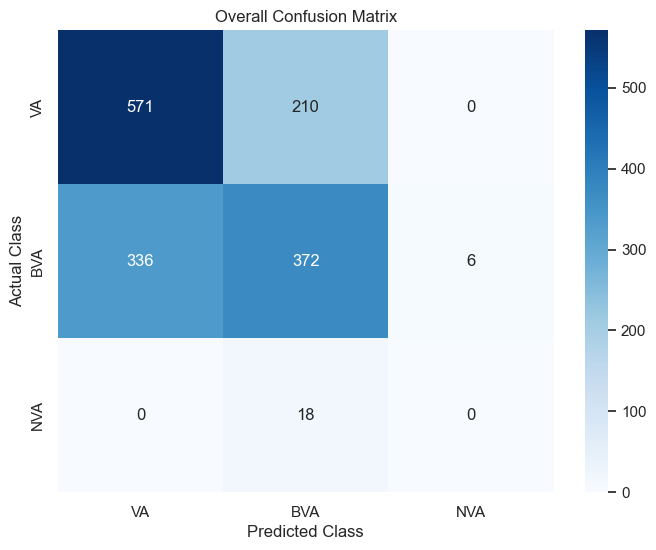

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Improve plot aesthetics
sns.set_theme(style="whitegrid")

# Define all possible confusion matrix columns
all_possible_columns = [
    'conf_VA_VA', 'conf_VA_BVA', 'conf_VA_NVA',
    'conf_BVA_VA', 'conf_BVA_BVA', 'conf_BVA_NVA',
    'conf_NVA_VA', 'conf_NVA_BVA', 'conf_NVA_NVA'
]

# Filter to only include columns that exist in the DataFrame
existing_columns = [col for col in all_possible_columns if col in data_df.columns]

# Sum confusion matrix components over all activities
confusion_matrix = data_df[existing_columns].sum()

# Prepare confusion matrix data
confusion_data = []

# Extract actual and predicted labels
for col in confusion_matrix.index:
    actual, predicted = col.split('_')[1], col.split('_')[2]
    count = confusion_matrix[col]
    confusion_data.append({'Actual': actual, 'Predicted': predicted, 'Count': count})

# Create DataFrame from the collected data
confusion_df = pd.DataFrame(confusion_data)

# Pivot the DataFrame to create a matrix
confusion_pivot = confusion_df.pivot(index='Actual', columns='Predicted', values='Count').fillna(0)

# Ensure all classes are present in both axes
all_classes = ['VA', 'BVA', 'NVA',]
for cls in all_classes:
    if cls not in confusion_pivot.index:
        confusion_pivot.loc[cls] = 0
    if cls not in confusion_pivot.columns:
        confusion_pivot[cls] = 0

# Sort the index and columns to ensure consistent order
confusion_pivot = confusion_pivot.reindex(index=all_classes, columns=all_classes, fill_value=0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_pivot, annot=True, fmt='g', cmap='Blues')
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

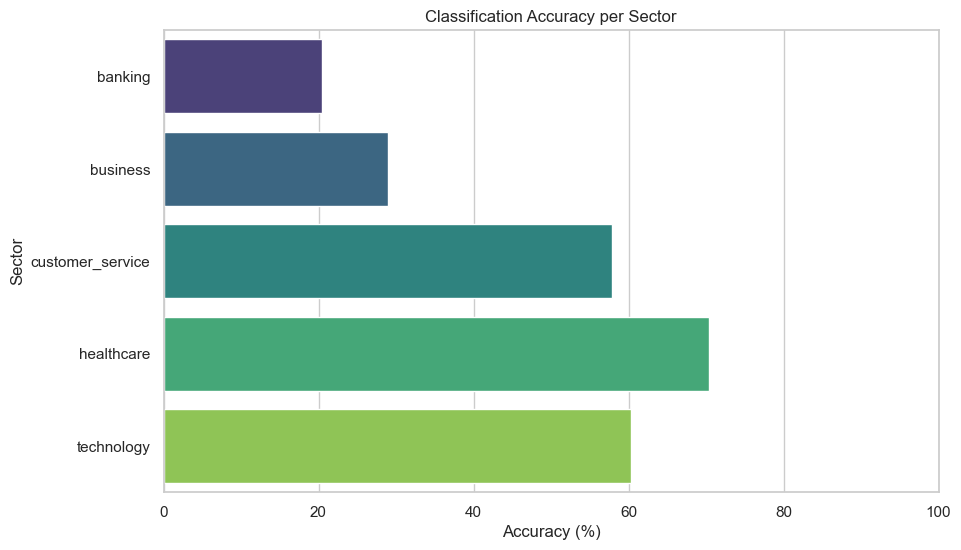

In [12]:
# Calculate mean accuracy per sector
sector_accuracy = data_df.groupby('sector')['accuracy'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='accuracy', y='sector', data=sector_accuracy, palette='viridis')
plt.title('Classification Accuracy per Sector')
plt.xlabel('Accuracy (%)')
plt.ylabel('Sector')
plt.xlim(0, 100)
plt.show()


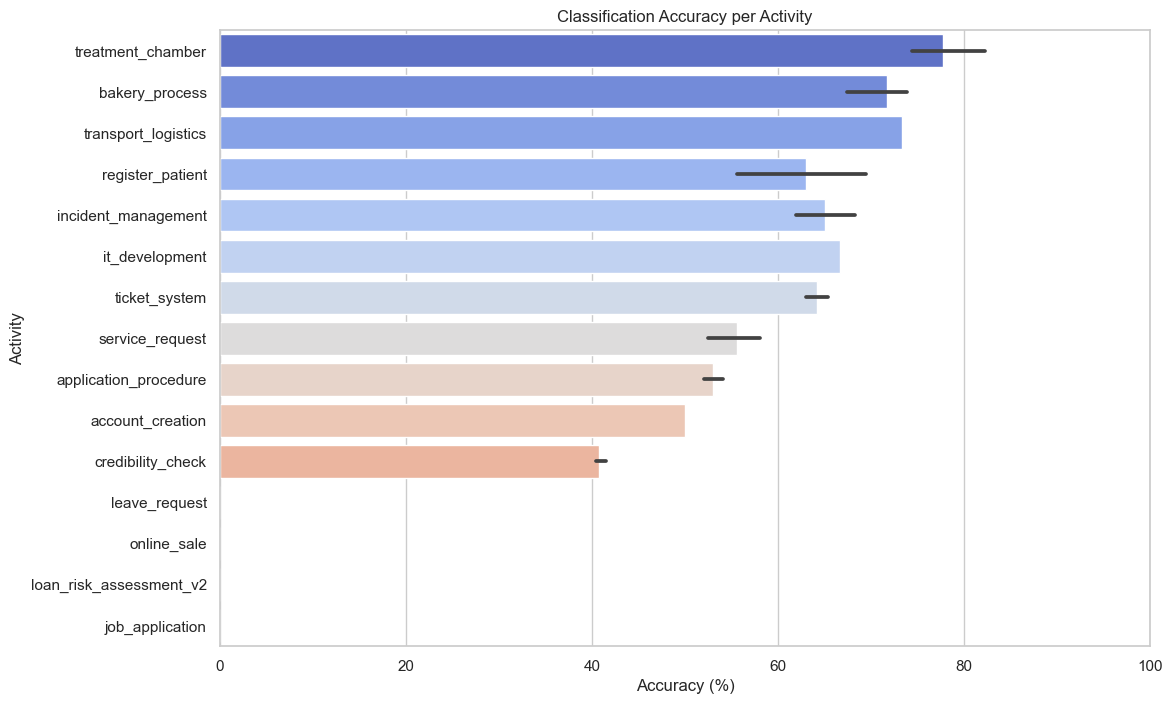

In [13]:
# Sort activities by accuracy
activity_accuracy = data_df[['activity', 'accuracy']].sort_values(by='accuracy', ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='accuracy', y='activity', data=activity_accuracy, palette='coolwarm')
plt.title('Classification Accuracy per Activity')
plt.xlabel('Accuracy (%)')
plt.ylabel('Activity')
plt.xlim(0, 100)  # Assuming accuracy is in percentage
plt.show()


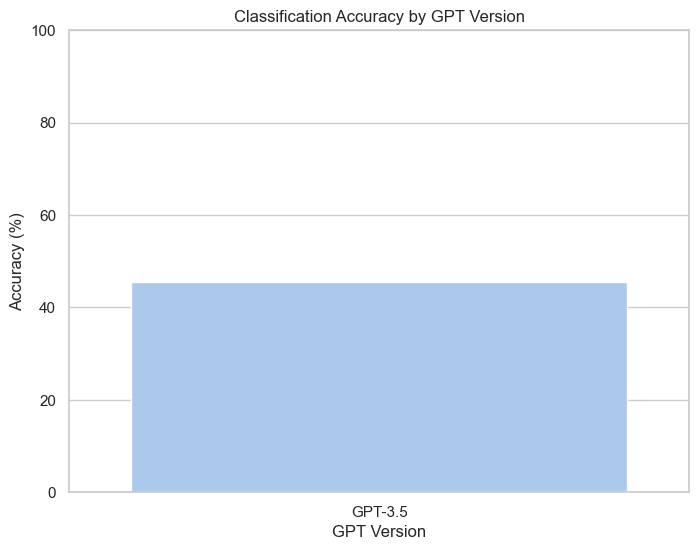

In [14]:
# Calculate mean accuracy per GPT version
gpt_accuracy = data_df.groupby('gpt_version')['accuracy'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='gpt_version', y='accuracy', data=gpt_accuracy, palette='pastel')
plt.title('Classification Accuracy by GPT Version')
plt.xlabel('GPT Version')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Assuming accuracy is in percentage
plt.show()


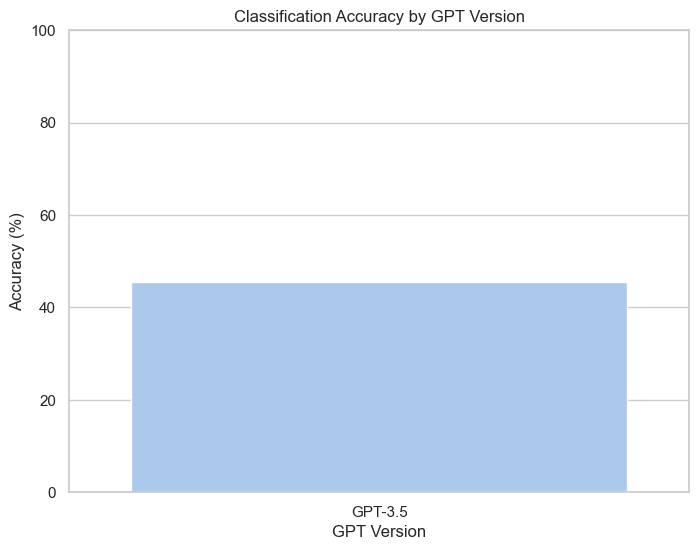

In [15]:
# Calculate mean accuracy per GPT version
gpt_accuracy = data_df.groupby('gpt_version')['accuracy'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='gpt_version', y='accuracy', data=gpt_accuracy, palette='pastel')
plt.title('Classification Accuracy by GPT Version')
plt.xlabel('GPT Version')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Assuming accuracy is in percentage
plt.show()


In [16]:
# Sum misclassifications per misclassification type
misclassifications = data_df[
    ['conf_VA_BVA', 'conf_VA_NVA', 
     'conf_BVA_VA', 'conf_BVA_NVA',
     'conf_NVA_VA', 'conf_NVA_BVA']
].sum().reset_index()

misclassifications.columns = ['Misclassification', 'Count']

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Misclassification', data=misclassifications, palette='flare')
plt.title('Types and Counts of Misclassifications')
plt.xlabel('Count')
plt.ylabel('Misclassification Type')
plt.show()


KeyError: "['conf_VA_NVA', 'conf_NVA_VA'] not in index"

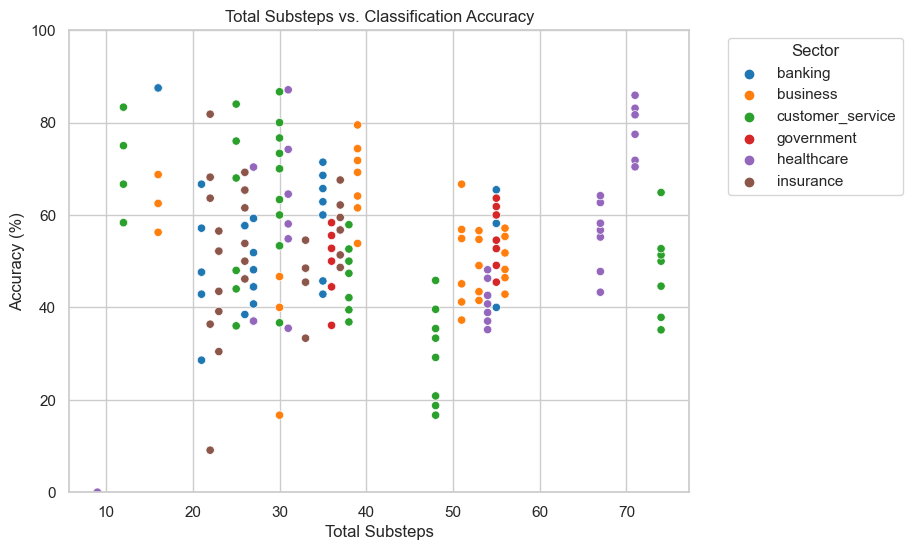

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_substeps', y='accuracy', hue='sector', data=data_df, palette='tab10')
plt.title('Total Substeps vs. Classification Accuracy')
plt.xlabel('Total Substeps')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Assuming accuracy is in percentage
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


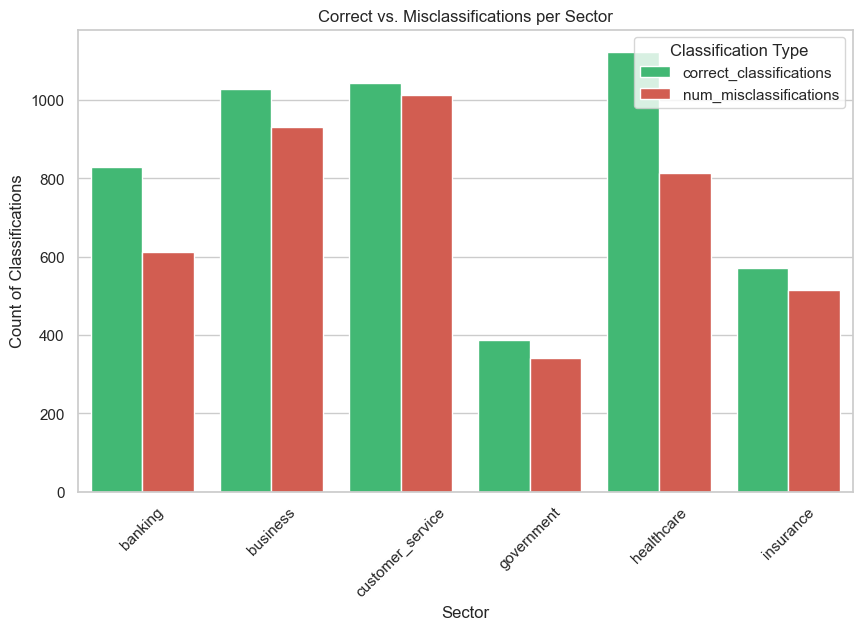

In [12]:
# Calculate total classifications per sector
sector_totals = data_df.groupby('sector')[['correct_classifications', 'num_misclassifications']].sum().reset_index()

# Melt DataFrame for plotting
sector_totals_melted = sector_totals.melt(id_vars='sector', value_vars=['correct_classifications', 'num_misclassifications'], var_name='Classification', value_name='Count')

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='sector', y='Count', hue='Classification', data=sector_totals_melted, palette=['#2ecc71', '#e74c3c'])
plt.title('Correct vs. Misclassifications per Sector')
plt.xlabel('Sector')
plt.ylabel('Count of Classifications')
plt.xticks(rotation=45)
plt.legend(title='Classification Type')
plt.show()


# Aggregated by Model


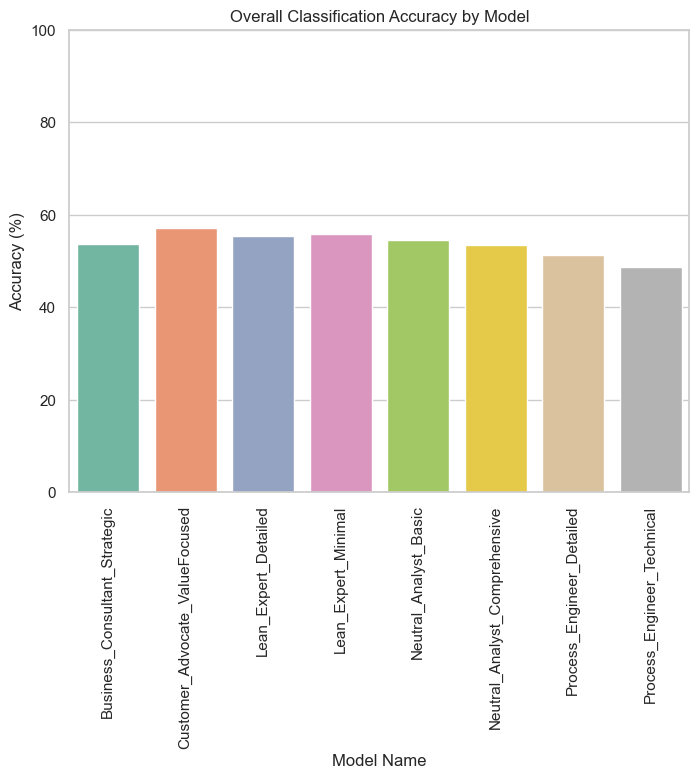

In [13]:
# Calculate mean accuracy per model
model_accuracy = data_df.groupby('model_name')['accuracy'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='model_name', y='accuracy', data=model_accuracy, palette='Set2')
plt.title('Overall Classification Accuracy by Model')
plt.xticks(rotation=90)
plt.xlabel('Model Name')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Assuming accuracy is in percentage
plt.show()


In [14]:
def calculate_nva_metrics(group):
    # True Positives (TP): Actual NVA correctly classified as NVA
    TP = group['conf_NVA_NVA'].sum()
    # False Positives (FP): Non-NVA misclassified as NVA
    FP = group[['conf_VA_NVA', 'conf_BVA_NVA']].sum().sum()
    # False Negatives (FN): Actual NVA misclassified as other classes
    FN = group[['conf_NVA_VA', 'conf_NVA_BVA']].sum().sum()
    
    # Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    # Recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    # F1 Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return pd.Series({'precision': precision * 100, 'recall': recall * 100, 'f1_score': f1_score * 100})

# Apply to each model
nva_metrics_by_model = data_df.groupby('model_name').apply(calculate_nva_metrics).reset_index()


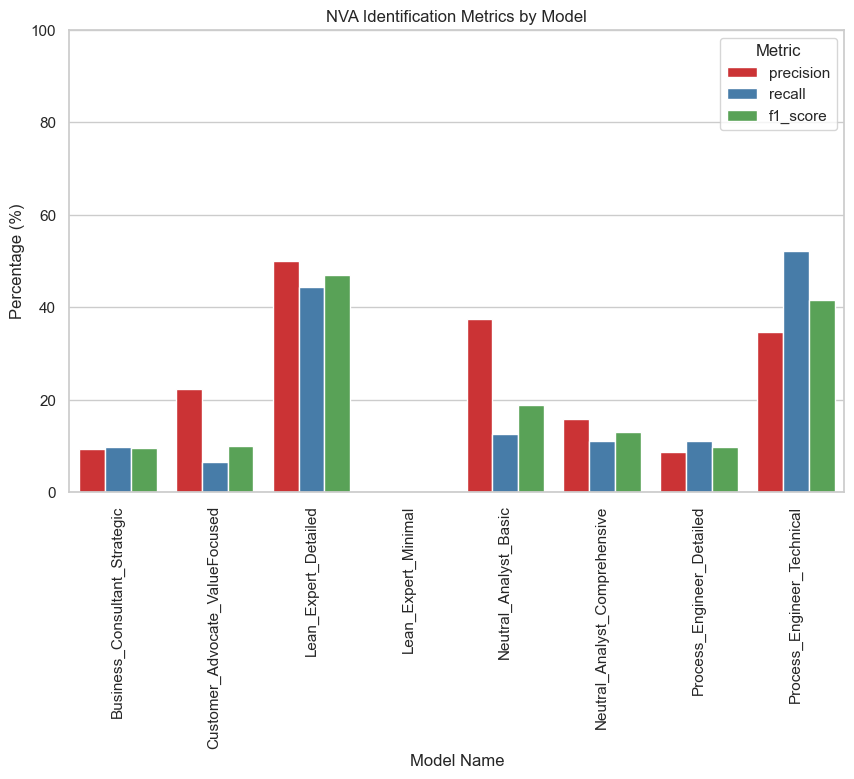

In [15]:
# Melt the DataFrame for plotting
nva_metrics_melted = nva_metrics_by_model.melt(
    id_vars='model_name',
    value_vars=['precision', 'recall', 'f1_score'],
    var_name='Metric',
    value_name='Percentage'
)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='model_name', y='Percentage', hue='Metric', data=nva_metrics_melted, palette='Set1')
plt.title('NVA Identification Metrics by Model')
plt.xlabel('Model Name')
plt.xticks(rotation=90)
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.legend(title='Metric')
plt.show()


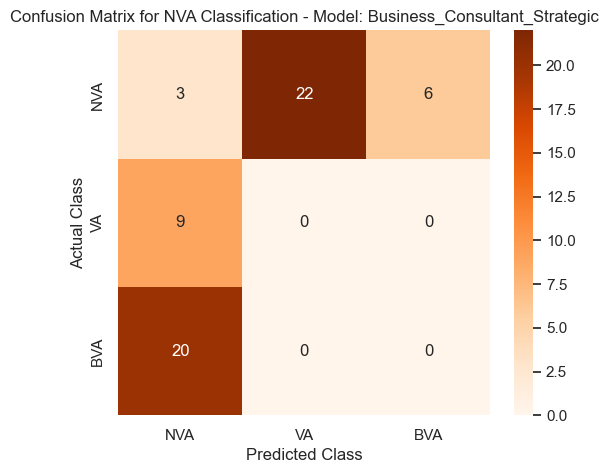

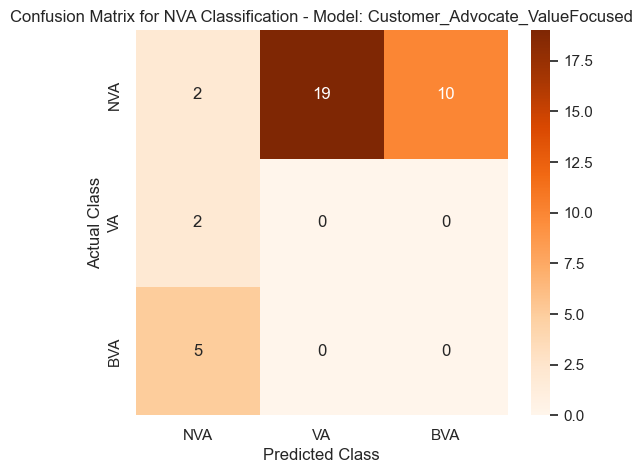

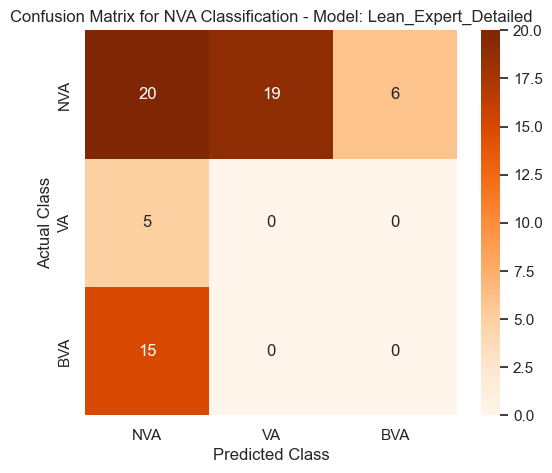

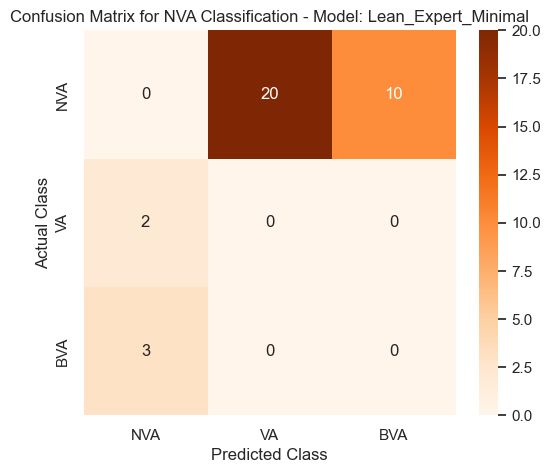

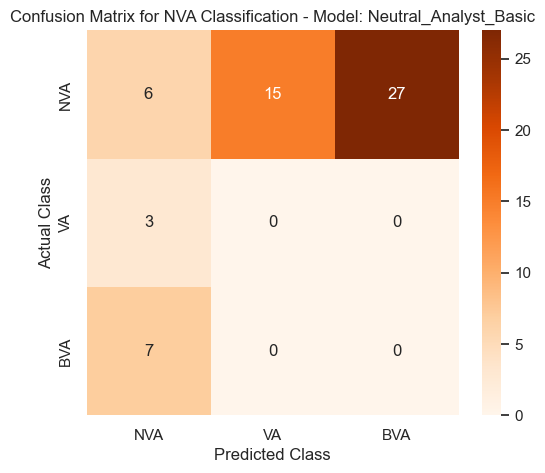

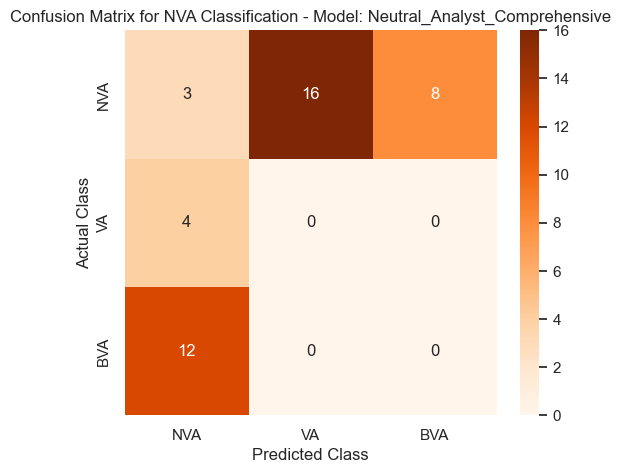

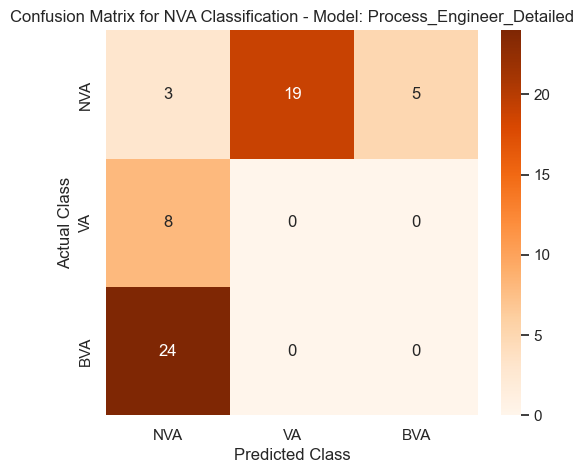

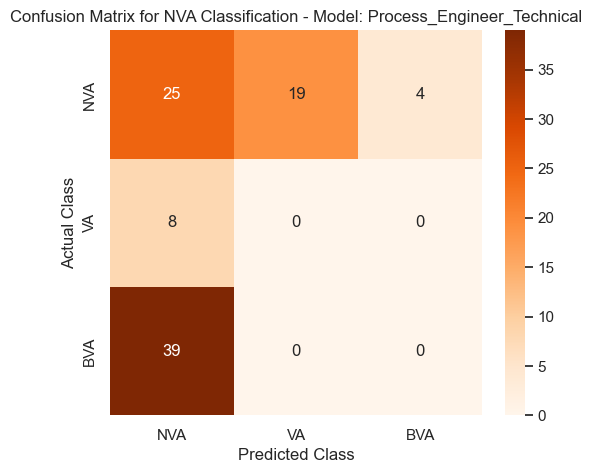

In [16]:
models = data_df['model_name'].unique()

for model in models:
    model_data = data_df[data_df['model_name'] == model]
    # Sum confusion matrix components for NVA classification
    confusion_values = model_data[
        ['conf_NVA_NVA', 'conf_NVA_VA', 'conf_NVA_BVA',
         'conf_VA_NVA', 'conf_BVA_NVA']
    ].sum()
    
    # Prepare data for confusion matrix DataFrame
    confusion_data = []
    
    nva_confusion_columns = ['conf_NVA_NVA', 'conf_NVA_VA', 'conf_NVA_BVA',
                             'conf_VA_NVA', 'conf_BVA_NVA']
    for col in nva_confusion_columns:
        actual, predicted = col.split('_')[1], col.split('_')[2]
        count = confusion_values[col]
        confusion_data.append({'Actual': actual, 'Predicted': predicted, 'Count': count})
    
    # Create confusion matrix DataFrame
    confusion_df = pd.DataFrame(confusion_data)
    
    # Pivot the DataFrame
    confusion_pivot = confusion_df.pivot(index='Actual', columns='Predicted', values='Count').fillna(0)
    
    # Ensure all classes are present
    all_classes = ['NVA', 'VA', 'BVA']
    for cls in all_classes:
        if cls not in confusion_pivot.index:
            confusion_pivot.loc[cls] = 0
        if cls not in confusion_pivot.columns:
            confusion_pivot[cls] = 0
    
    # Sort the index and columns to ensure consistent order
    confusion_pivot = confusion_pivot.reindex(index=all_classes, columns=all_classes, fill_value=0)
    
    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_pivot, annot=True, fmt='g', cmap='Oranges')
    plt.title(f'Confusion Matrix for NVA Classification - Model: {model}')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

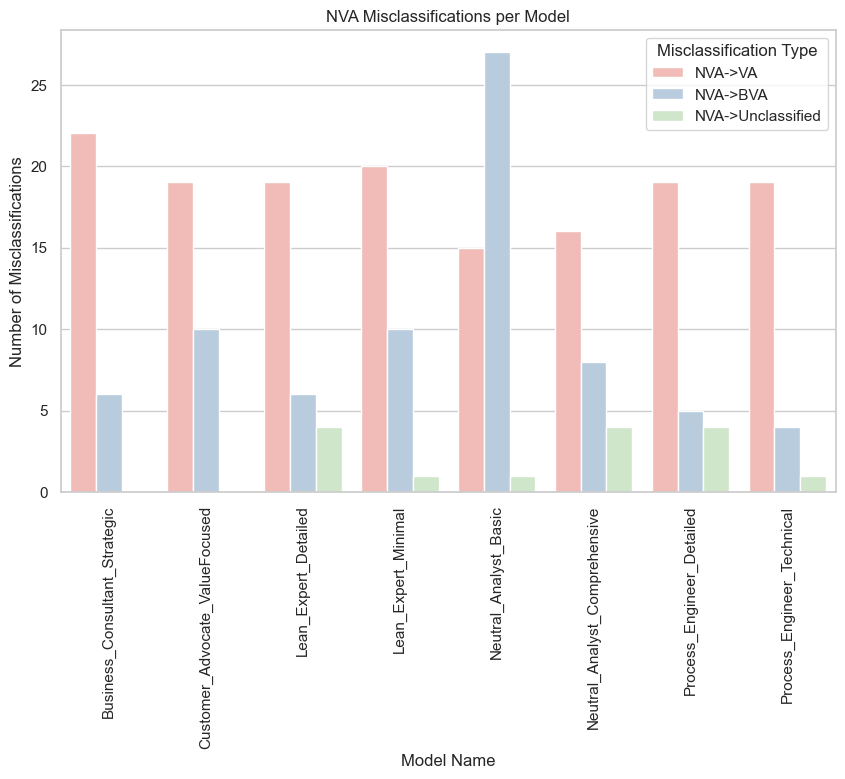

In [18]:
# Calculate NVA misclassifications per model
def nva_misclassifications(group):
    misclassifications = group[['conf_NVA_VA', 'conf_NVA_BVA', 'conf_NVA_Unclassified']].sum()
    total_misclassified = misclassifications.sum()
    return pd.Series({
        'NVA->VA': group['conf_NVA_VA'].sum(),
        'NVA->BVA': group['conf_NVA_BVA'].sum(),
        'NVA->Unclassified': group['conf_NVA_Unclassified'].sum(),
        'Total Misclassified NVA': total_misclassified
    })

nva_misclassifications_by_model = data_df.groupby('model_name').apply(nva_misclassifications).reset_index()

# Melt DataFrame for plotting
nva_misclassifications_melted = nva_misclassifications_by_model.melt(
    id_vars='model_name',
    value_vars=['NVA->VA', 'NVA->BVA', 'NVA->Unclassified'],
    var_name='Misclassification Type',
    value_name='Count'
)

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='model_name', y='Count', hue='Misclassification Type',
    data=nva_misclassifications_melted, palette='Pastel1'
)
plt.title('NVA Misclassifications per Model')
plt.xticks(rotation=90)
plt.xlabel('Model Name')
plt.ylabel('Number of Misclassifications')
plt.legend(title='Misclassification Type')
plt.show()


# Confusion Matrix


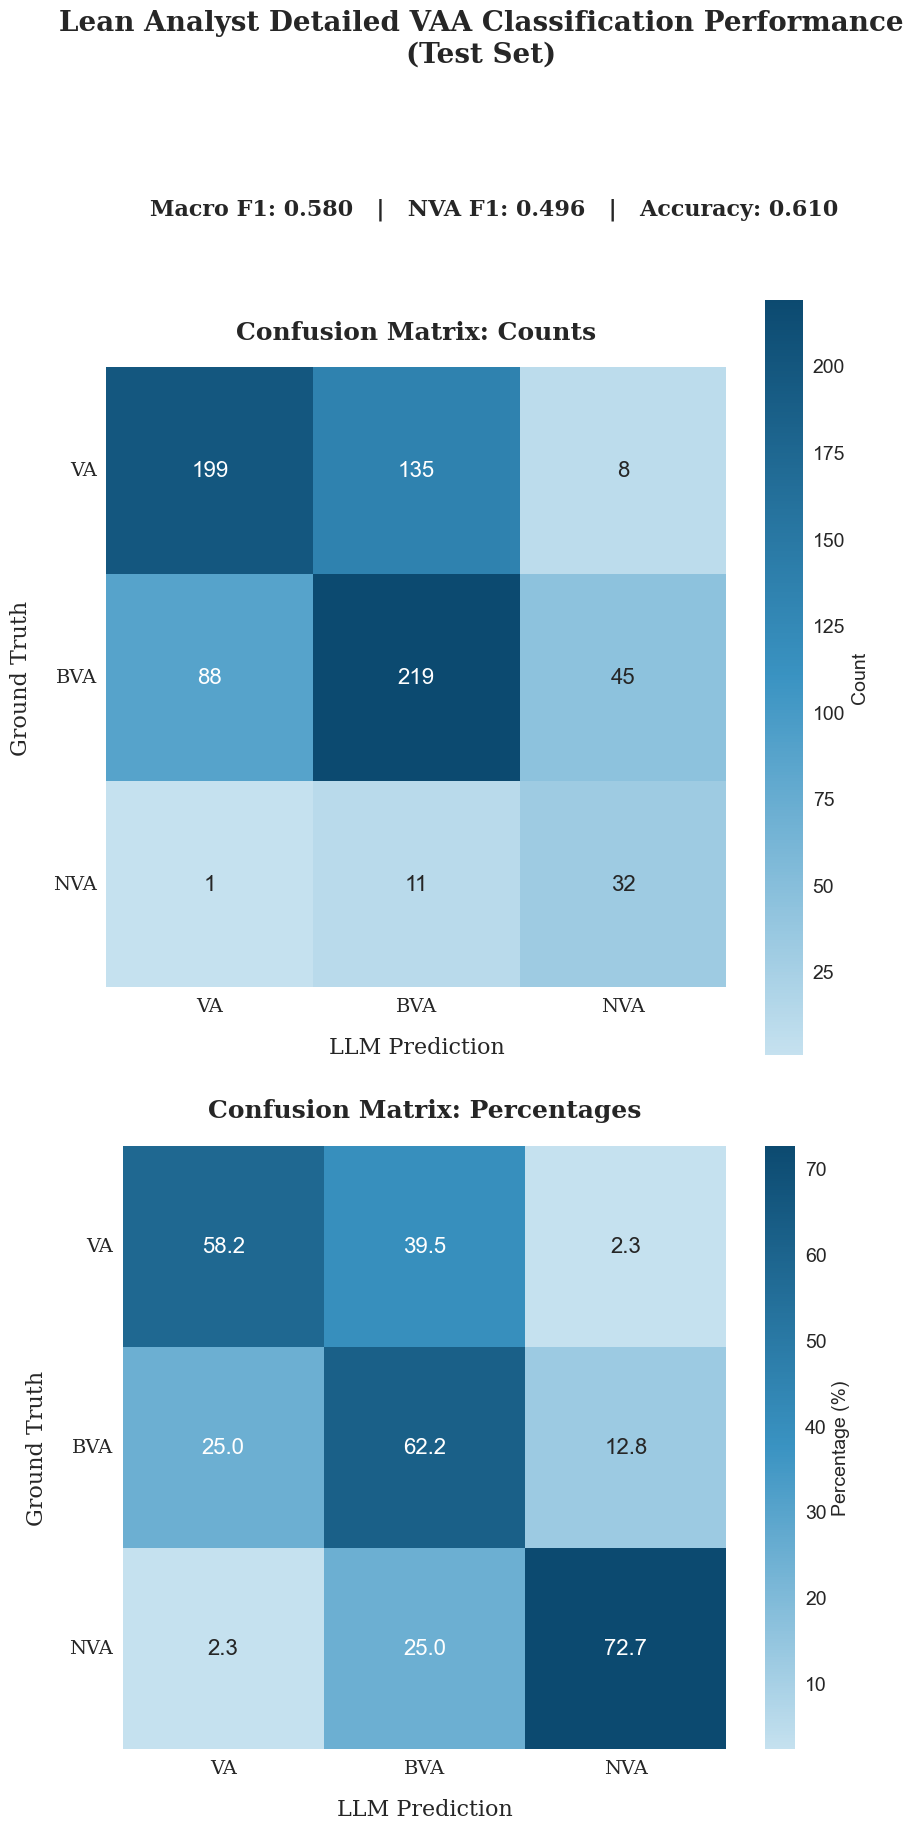


Detailed Metrics (Test Set):
Accuracy: 0.610
Macro F1: 0.580
NVA F1: 0.496

Classification Report (Test Set):
              precision    recall  f1-score   support

          VA       0.69      0.58      0.63       342
         BVA       0.60      0.62      0.61       352
         NVA       0.38      0.73      0.50        44

    accuracy                           0.61       738
   macro avg       0.56      0.64      0.58       738
weighted avg       0.63      0.61      0.61       738



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.colors as mcolors
import pandas as pd

def plot_dual_confusion_matrices(y_true, y_pred, set_type='train', model_name="", figsize=(10, 20), save_path=None):
    """
    Plot two confusion matrices vertically with ordered categories, larger fonts, and improved spacing.
    """
    # Define category order
    category_order = ['VA', 'BVA', 'NVA']
    
    # Calculate additional metrics
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, labels=category_order, average='macro')
    nva_f1 = f1_score(y_true, y_pred, labels=category_order, average=None)[2]  # NVA is index 2
    
    # Create confusion matrix with ordered labels
    cm = confusion_matrix(y_true, y_pred, labels=category_order)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Set up the plot
    fig = plt.figure(figsize=figsize)
    
    # Create subplot grid with more space between plots
    gs = plt.GridSpec(3, 1, height_ratios=[0, 1, 0.8])#, hspace=0.4)
    
    # Add metrics text at the top with larger font
    plt.subplot(gs[0])
    metrics_text = f'Macro F1: {macro_f1:.3f}   |   NVA F1: {nva_f1:.3f}   |   Accuracy: {accuracy:.3f}'
    plt.text(0.5, 0.5, metrics_text, ha='center', va='center',
             fontsize=16, fontweight='bold', fontfamily='serif')
    plt.axis('off')
    
    # Create the heatmap subplots
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    
    # Create custom colormap with updated colors
    colors = ['#c5e1ef', '#3a93c2', '#0c4a70']
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)
    
    # Common kwargs for both heatmaps
    common_kwargs = dict(
        square=True,
        xticklabels=category_order,
        yticklabels=category_order,
        cmap=custom_cmap
    )
    
    # Plot counts (top)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                ax=ax1,
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 16},
                **common_kwargs)
    
    # Plot percentages (bottom)
    sns.heatmap(cm_percent,
                annot=True,
                fmt='.1f',
                ax=ax2,
                cbar_kws={'label': 'Percentage (%)'},
                annot_kws={'size': 16},
                **common_kwargs)
    
    # Customize the plots with larger fonts
    for ax, title in zip([ax1, ax2], ['Counts', 'Percentages']):
        ax.set_title(f'Confusion Matrix: {title}', 
                    pad=20,
                    fontsize=18,
                    fontweight='bold',
                    fontfamily='serif')
        
        ax.set_xlabel('LLM Prediction', fontsize=16, fontfamily='serif', labelpad=15)
        ax.set_ylabel('Ground Truth', fontsize=16, fontfamily='serif', labelpad=15)
        
        # Adjust font sizes
        ax.tick_params(labelsize=14)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontfamily('serif')
            label.set_fontsize(14)
        
        # Rotate the tick labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
        plt.setp(ax.get_yticklabels(), rotation=0, va='center')
        
        # Adjust colorbar font size
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.yaxis.label.set_size(14)
    
    # Add super title with larger font
    plt.suptitle(f'{model_name} VAA Classification Performance\n({set_type.title()} Set)', 
                 fontsize=20, 
                 fontweight='bold', 
                 fontfamily='serif',
                 y=0.98)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, pad_inches=0.5)
    
    plt.show()
    
    # Print detailed metrics
    print(f"\nDetailed Metrics ({set_type.title()} Set):")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Macro F1: {macro_f1:.3f}")
    print(f"NVA F1: {nva_f1:.3f}")
    
    # Print classification report
    print(f"\nClassification Report ({set_type.title()} Set):")
    print(classification_report(y_true, y_pred, labels=category_order))

# Generate and plot both train and test sets
for set_type in ['train', 'test']:
    if set_type == 'train':
        continue
    model_name = "Lean Analyst Detailed"
    
        
    # transition_probs = {
    #     'VA':  [0.9, 0.1, 0.0],  # VA -> [VA, BVA, NVA]
    #     'BVA': [0.2, 0.7, 0.10],  # BVA -> [VA, BVA, NVA]
    #     'NVA': [0.2, 0.6, 0.20]   # NVA -> [VA, BVA, NVA]
    # }
    
    plot_dual_confusion_matrices(true_labels, predictions, set_type, model_name=model_name, save_path=f"vaa_{model_name}_confusion_matrix_{set_type}.png")

# Performance Metrics


C:\Users\wmichele\AppData\Local\Temp\ipykernel_40528\2839765844.py:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


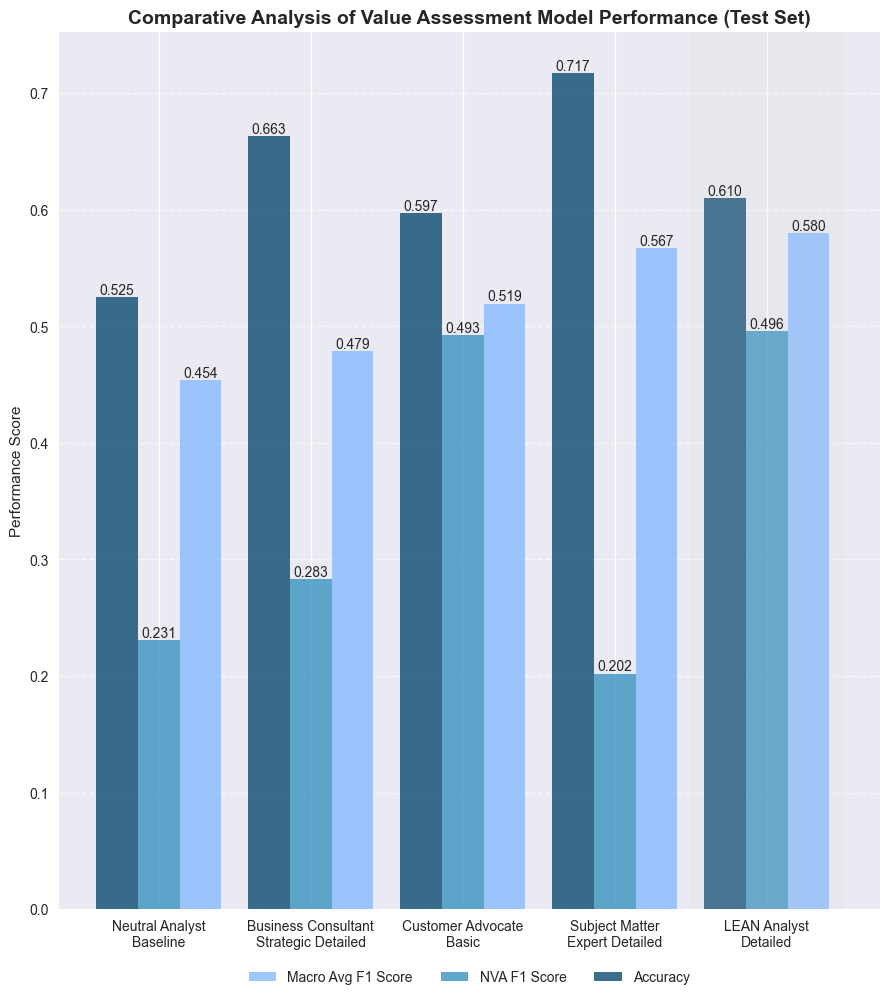

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Original data
data_original = {
    'Model': [
        'Subject Matter Expert Detailed',
        'LEAN Analyst Detailed',
        'Customer Advocate Basic',
        'Business Consultant Strategic Detailed',
        'Neutral Analyst\nBaseline'
    ],
    'Macro Avg F1 Score': [0.588, 0.617, 0.446, 0.407, 0.443],
    'NVA F1 Score': [0.207, 0.570, 0.536, 0.215, 0.153],
    'Accuracy': [0.744, 0.637, 0.567, 0.674, 0.534]
}

# Create test data with random decreases up to 0.05
np.random.seed(42)  # For reproducibility
data_test = {
    'Model': [
        'Subject Matter\nExpert Detailed', 
        'LEAN Analyst\nDetailed', 
        'Customer Advocate\nBasic', 
        'Business Consultant\nStrategic Detailed', 
        'Neutral Analyst\nBaseline'
    ], 
    'Macro Avg F1 Score': [0.567, 0.580, 0.51940030290942975, 0.479, 0.454], 
    'NVA F1 Score': [0.202, 0.496, 0.4926911927112533, 0.283, 0.231], 
    'Accuracy': [0.717, 0.610, 0.5973778679599789, 0.6633830444660862, 0.524908751639645]
}

# Create DataFrames
df_original = pd.DataFrame(data_original)
df_test = pd.DataFrame(data_test)

# Sort both datasets by Macro Avg F1 Score, keeping baseline at the bottom
def sort_with_baseline(df):
    baseline_row = df[df['Model'] == 'Neutral Analyst Baseline']
    other_rows = df[df['Model'] != 'Neutral Analyst Baseline'].sort_values('Macro Avg F1 Score', ascending=True)
    return pd.concat([other_rows, baseline_row])

df_original_sorted = sort_with_baseline(df_original)
df_test_sorted = sort_with_baseline(df_test)

def plot_vaa_metrics(df_original_sorted, title_suffix="(Training Set)"):
    # Plotting
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(9, 10))  # Swapped dimensions for vertical orientation

    # Define colors and positions
    colors = ['#89bbff', '#3a93c2', '#0c4a70']
    x_pos = np.arange(len(df_original_sorted['Model']))
    bar_width = 0.275
    opacity = 0.8

    # Create bars in desired order with adjusted positions
    # Macro Avg F1 Score (rightmost bar)
    plt.bar(x_pos + bar_width, df_original_sorted['Macro Avg F1 Score'], 
            bar_width, alpha=opacity, color=colors[0], 
            label='Macro Avg F1 Score')
    # NVA F1 Score (middle bar)
    plt.bar(x_pos, df_original_sorted['NVA F1 Score'], 
            bar_width, alpha=opacity, color=colors[1], 
            label='NVA F1 Score')
    # Accuracy (leftmost bar)
    plt.bar(x_pos - bar_width, df_original_sorted['Accuracy'], 
            bar_width, alpha=opacity, color=colors[2], 
            label='Accuracy')

    # Customize the plot
    plt.ylabel('Performance Score')
    plt.xlabel('')
    title = f'Comparative Analysis of Value Assessment Model Performance {title_suffix}'
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(x_pos, df_original_sorted['Model'])

    # Highlight baseline with different background
    baseline_idx = df_original_sorted[df_original_sorted['Model'] == 'Neutral Analyst\nBaseline'].index[0]
    ax.axvspan(baseline_idx - 0.5, baseline_idx + 0.5, color='lightgray', alpha=0.1)

    # Add gridlines
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend within the plot
    plt.legend(bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=3)

    # Add value labels on the bars
    def add_labels(x_pos, values, offset):
        for i, v in enumerate(values):
            ax.text(x_pos[i] + offset, v, f'{v:.3f}', 
                    ha='center', va='bottom', fontsize=10)

    add_labels(x_pos + bar_width, df_original_sorted['Macro Avg F1 Score'], 0)
    add_labels(x_pos, df_original_sorted['NVA F1 Score'], 0)
    add_labels(x_pos - bar_width, df_original_sorted['Accuracy'], 0)
    
    # Save the plot
    plt.savefig(f'vaa_metrics_comparison_{title_suffix}.png', bbox_inches='tight', dpi=300)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# Generate both plots
# plot_vaa_metrics(df_original_sorted, "(Training Set)")
plot_vaa_metrics(df_test_sorted, "(Test Set)")